# Transformer 익스 


In [50]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print("슝=3")


슝=3


In [51]:

csv_path = os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData.csv'

data = pd.read_csv(csv_path)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


## 데이터 파악하기 

* 질문에 챗봇이 답하는 방식 
* training : 11823
* 0 : 중립 , 1: 부정 , 2: 긍정 
* 결측치 없다 


Q,A,label로 구성이 되어있다 


In [52]:
MAX_DATA_LEN = len(data)
print(MAX_DATA_LEN)

11823


In [53]:
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [54]:
# 전처리 함수
def preprocess_sentence(sentence):
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence



In [55]:
# 확인 해보기 
print("질문 확인하기 ")
for i in range(5):
    print(preprocess_sentence(data["Q"][i]))

    
    
print("-----------------------------------------")
print("답변 확인하기 ")
for i in range(5):
    print(preprocess_sentence(data["A"][i]))


질문 확인하기 
12시 땡 !
1지망 학교 떨어졌어
3박4일 놀러가고 싶다
3박4일 정도 놀러가고 싶다
PPL 심하네
-----------------------------------------
답변 확인하기 
하루가 또 가네요 .
위로해 드립니다 .
여행은 언제나 좋죠 .
여행은 언제나 좋죠 .
눈살이 찌푸려지죠 .


In [56]:
# 질문과 답변의 쌍인 데이터 셋 구성하기 위한 데이터 로드 함수 

def load_conversations():
    inputs,outputs=[],[]
    
    for i in range(MAX_DATA_LEN):
        # input output 리스트에 Q, A에 대해 전처리한거 적용하기
        inputs.append(preprocess_sentence(data["Q"][i]))
        outputs.append(preprocess_sentence(data["A"][i]))
    
    return inputs,outputs


In [57]:
# 확인하기 
Q,A = load_conversations()
print('전처리 후의 15번째 질문 샘플: {}'.format(Q[21]))
print('전처리 후의 15번째 답변 샘플: {}'.format(A[21]))

전처리 후의 15번째 질문 샘플: 가스비 장난 아님
전처리 후의 15번째 답변 샘플: 다음 달에는 더 절약해봐요 .


## SubwordTextEncoder 사용하기 

단어 분리 작업은 하나의 단어를 여러 내부 단어로 분리 해서 단어를 이해해보겠다는 의도를 가진 전처리 작업이다 

1. 배운적 없는 단어에 대해(OOV,UNT)등에 대해 어느 정도 대처 가능 
2. 단어가 많아질수록 학습해야 할양 늘어나는데 이를 줄일수있다 






In [58]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(Q + A, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [59]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")


슝=3


In [60]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


In [61]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


### subwordtextencoder에서 .encoder를 이용해서 정수 인코딩 진행 가능하다 


In [62]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
print('정수 인코딩 후의 15번째 질문 샘플: {}'.format(tokenizer.encode(Q[15])))
print('정수 인코딩 후의 15번째 답변 샘플: {}'.format(tokenizer.encode(A[15])))

# decoder이용해서 기존 문장 확인하기 
print('기존 문장 15번째 질문 샘플: {}'.format(tokenizer.decode(tokenizer.encode(Q[15]))))
print('기존 문장 15번째 답변 샘플: {}'.format(tokenizer.decode(tokenizer.encode(A[15]))))


정수 인코딩 후의 15번째 질문 샘플: [78, 62, 1145, 5485, 1574]
정수 인코딩 후의 15번째 답변 샘플: [7397, 452, 2168, 105, 1]
기존 문장 15번째 질문 샘플: 가만 있어도 땀난다
기존 문장 15번째 답변 샘플: 땀을 식혀주세요 .


In [63]:
for ts in tokenizer.encode(Q[15]):
      print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

78 ----> 가
62 ----> 만 
1145 ----> 있어도 
5485 ----> 땀
1574 ----> 난다


In [64]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [65]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
# 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

      
    return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [66]:
Q, A = tokenize_and_filter(Q, A)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(Q)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(A)))

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


## teacher Forcing  적용하기 



In [67]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 입력과 실제값 시퀀스를 구성한다 

dataset = tf.data.Dataset.from_tensor_slices(({
    "inputs" : Q,
    "dec_inputs":A[:,:-1] # 디코더의 입력, END Token 제거 된다 
    
},
{
    "outputs":A[:,1:] # START Token 제거 
}))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


# 트랜스 포머 모델 구성 하기 



In [68]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


In [69]:
# Attention 

# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가 -> Decoder padding 위함
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

print("슝=3")

슝=3


In [70]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0 # 나눠줘야 정상

        self.depth = d_model // self.num_heads # head의 깊이를 의미 

        # 임베딩 차원 만큼 만들기 embedding *head
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    # head 개수 만큼 나눈다 
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다 -> 여기서 각 head 깊이 만큼 나눠진다 
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs
print("슝=3")

슝=3


### MASKING 



In [71]:
# Encoder에 대한 padding 작업 
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [72]:
# Decoder에 대한 패딩 작업 
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [73]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [74]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    
    
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    #원드 벡터임베딩 
    # 임베딩 레이어 
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층. 논문에서는 6개
    # 워드 임베딩 + 포지션 나온 결과물을 ecoder layer에서 처리 
    for i in range(num_layers):
        
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [75]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션) 디코더 입력에 따른 어텐션
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask})
    
    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

print("슝=3")

슝=3


In [76]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행 -> 워드 벡터 + 포지션 과정 결과 
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 레이터 개수 만큼 디코더 돌아간다 
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
    
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
print("슝=3")

슝=3


## 트랜스포머 구성 하기 

In [77]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    
    
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)
    
    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,)(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


## 모델 생성 

In [78]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 256# 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)


model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    5255424     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### loss 함수 커스텀 

레이블인 시퀀스에 패딩이 있다 이에 맞는 loss 함수 필요 

In [79]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

print("슝=3")

슝=3


In [80]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
    
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

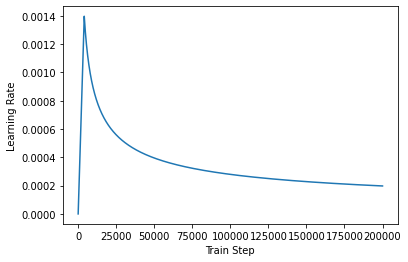

In [81]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [82]:
# 컴파일 
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [83]:
# 훈련 
EPOCHS = 200
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/200
185/185 [==============================] - 39s 122ms/step - loss: 1.4448 - accuracy: 0.0221
Epoch 2/200
185/185 [==============================] - 23s 124ms/step - loss: 1.1938 - accuracy: 0.0412
Epoch 3/200
185/185 [==============================] - 23s 124ms/step - loss: 1.0251 - accuracy: 0.0499
Epoch 4/200
185/185 [==============================] - 23s 125ms/step - loss: 0.9537 - accuracy: 0.0524
Epoch 5/200
185/185 [==============================] - 23s 125ms/step - loss: 0.9139 - accuracy: 0.0544
Epoch 6/200
185/185 [==============================] - 23s 125ms/step - loss: 0.8808 - accuracy: 0.0562
Epoch 7/200
185/185 [==============================] - 23s 126ms/step - loss: 0.8494 - accuracy: 0.0576
Epoch 8/200
185/185 [==============================] - 23s 125ms/step - loss: 0.8169 - accuracy: 0.0593
Epoch 9/200
185/185 [==============================] - 23s 125ms/step - loss: 0.7820 - accuracy: 0.0612
Epoch 10/200
185/185 [==============================] - 23s 126m

## 모델 평가 하기 

In [84]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    #  디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [85]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence
print("슝=3")

슝=3


In [86]:
input_list =[
    "안녕?",
    "고민이있어",
    "위로해줘",
    "오늘 하루 즐거웠어",
    "놀자",
    "게임하고 싶다",
    "쉬고 싶어",
    "잠을 못자",
    "잠을 요즘 너무 많이 자",
    "짜증나",
    "왜그래?",
    "뭐 먹을래?",
    "메뉴 추천해줘",
    "안녕하세요 오늘 하루 정말 즐거웠어요 오늘 하루 어땠나요? 좋았나요? 저한테 말을 해주세요 "
    
            ]

In [87]:
for i in input_list:
    
    sentence_generation(i)

입력 : 안녕?
출력 : 안녕하세요 .
입력 : 고민이있어
출력 : 더 많아도 괜찮아요 .
입력 : 위로해줘
출력 : 힘내세요 .
입력 : 오늘 하루 즐거웠어
출력 : 능력이라면 능력이겠죠 .
입력 : 놀자
출력 : 혼자 사는 것도 나쁘지 않아요 .
입력 : 게임하고 싶다
출력 : 게임하세요 !
입력 : 쉬고 싶어
출력 : 아무 생각 하지 말고 쉬세요 .
입력 : 잠을 못자
출력 : 잠이 최고의 보약이에요 . 노력해보세요 .
입력 : 잠을 요즘 너무 많이 자
출력 : 노력하겠습니다 .
입력 : 짜증나
출력 : 짜증날 때는 기분 푸는 음악 어때요 ?
입력 : 왜그래?
출력 : 어떻게 하느냐에 따라 달라질 거예요 .
입력 : 뭐 먹을래?
출력 : 듀엣곡 연습하고 가세요 .
입력 : 메뉴 추천해줘
출력 : 구두로 멋을 내보세요 .
입력 : 안녕하세요 오늘 하루 정말 즐거웠어요 오늘 하루 어땠나요? 좋았나요? 저한테 말을 해주세요 
출력 : 진심으로 마음을 전해보세요 .


# 회고 

전반적인 코드를 보고 트랜스포머의 논문 내용을 이해해볼수있는 시간이었다. 챗봇 예제를 몇개 만들고 decode해본 결과 거의 만족할만한 결과가 나온것 같다  

NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수  
D_MODEL = 256# 인코더와 디코더 내부의 입, 출력의 고정 차원  
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수   
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기  
DROPOUT = 0.1 # 드롭아웃의 비율  

하이퍼 파라미터 설정은 위에 처럼 head를 16개로 해주고 layer수를 6개로 바꾸어주었다  
문장의 길이가 40이상인 문장에 대해서는 인식이 잘 안되고 짧은 문장에 대해서는 어느정도 괜찮은 결과가 나온것 같다 

평가 방식이 따로 찾지 못했는데 모델의 성능을 평가 못한게 아쉬웠다